## Load the houseprices data from Thinkful's database.

In [1]:
from sqlalchemy import create_engine
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()


# I also loaded in a dataset containing economic data to use later on in this challenge (shown below in output)
int_rates_df=pd.read_csv('/Users/steveangeli/Downloads/index.csv')
int_rates_df.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [2]:
# This is where I get the data I want from the economic dataset and merge it with my houses_df.
avg_rates = pd.DataFrame()
avg_rates['Federal_Funds_Rate'] = int_rates_df.groupby('Year')['Effective Federal Funds Rate'].mean()
avg_rates['Unemployment_Rate'] = int_rates_df.groupby('Year')['Unemployment Rate'].mean()
avg_rates['Inflation_Rate'] = int_rates_df.groupby('Year')['Inflation Rate'].mean()
avg_rates.head()

houses_df = pd.merge(houses_df, avg_rates, how='left', left_on='yrsold', right_on='Year')
houses_df.head(25)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,Federal_Funds_Rate,Unemployment_Rate,Inflation_Rate
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,None,0,2,2008,WD,Normal,208500,1.927500,5.800000,2.308333
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,None,0,5,2007,WD,Normal,181500,5.019167,4.616667,2.325000
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,None,0,9,2008,WD,Normal,223500,1.927500,5.800000,2.308333
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,None,0,2,2006,WD,Abnorml,140000,4.964167,4.608333,2.491667
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,None,0,12,2008,WD,Normal,250000,1.927500,5.800000,2.308333
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,Shed,700,10,2009,WD,Normal,143000,0.160000,9.283333,1.691667
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,None,0,8,2007,WD,Normal,307000,5.019167,4.616667,2.325000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,Shed,350,11,2009,WD,Normal,200000,0.160000,9.283333,1.691667
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,None,0,4,2008,WD,Abnorml,129900,1.927500,5.800000,2.308333
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,None,0,1,2008,WD,Normal,118000,1.927500,5.800000,2.308333


## Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [3]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 84 columns):
id                    1460 non-null int64
mssubclass            1460 non-null int64
mszoning              1460 non-null object
lotfrontage           1201 non-null float64
lotarea               1460 non-null int64
street                1460 non-null object
alley                 91 non-null object
lotshape              1460 non-null object
landcontour           1460 non-null object
utilities             1460 non-null object
lotconfig             1460 non-null object
landslope             1460 non-null object
neighborhood          1460 non-null object
condition1            1460 non-null object
condition2            1460 non-null object
bldgtype              1460 non-null object
housestyle            1460 non-null object
overallqual           1460 non-null int64
overallcond           1460 non-null int64
yearbuilt             1460 non-null int64
yearremodadd          1460 non-null int6

In [4]:
houses_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,Federal_Funds_Rate,Unemployment_Rate,Inflation_Rate
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,None,0,2,2008,WD,Normal,208500,1.927500,5.800000,2.308333
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,None,0,5,2007,WD,Normal,181500,5.019167,4.616667,2.325000
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,None,0,9,2008,WD,Normal,223500,1.927500,5.800000,2.308333
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,None,0,2,2006,WD,Abnorml,140000,4.964167,4.608333,2.491667
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,None,0,12,2008,WD,Normal,250000,1.927500,5.800000,2.308333
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,Shed,700,10,2009,WD,Normal,143000,0.160000,9.283333,1.691667
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,None,0,8,2007,WD,Normal,307000,5.019167,4.616667,2.325000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,Shed,350,11,2009,WD,Normal,200000,0.160000,9.283333,1.691667
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,None,0,4,2008,WD,Abnorml,129900,1.927500,5.800000,2.308333
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,None,0,1,2008,WD,Normal,118000,1.927500,5.800000,2.308333


In [5]:
for column_name in houses_df:
        print("Percent null values in {} : {}".format(column_name, 100*houses_df[column_name].isnull().sum()/houses_df[column_name].isnull().count()))

Percent null values in id : 0.0
Percent null values in mssubclass : 0.0
Percent null values in mszoning : 0.0
Percent null values in lotfrontage : 17.73972602739726
Percent null values in lotarea : 0.0
Percent null values in street : 0.0
Percent null values in alley : 93.76712328767124
Percent null values in lotshape : 0.0
Percent null values in landcontour : 0.0
Percent null values in utilities : 0.0
Percent null values in lotconfig : 0.0
Percent null values in landslope : 0.0
Percent null values in neighborhood : 0.0
Percent null values in condition1 : 0.0
Percent null values in condition2 : 0.0
Percent null values in bldgtype : 0.0
Percent null values in housestyle : 0.0
Percent null values in overallqual : 0.0
Percent null values in overallcond : 0.0
Percent null values in yearbuilt : 0.0
Percent null values in yearremodadd : 0.0
Percent null values in roofstyle : 0.0
Percent null values in roofmatl : 0.0
Percent null values in exterior1st : 0.0
Percent null values in exterior2nd :

In [6]:
# Create some easy short hands for numeric and non-numeric column names.

non_numeric_columns = houses_df.select_dtypes(['object']).columns
numeric_columns = houses_df.select_dtypes(['int64', 'float64']).columns

# See if any of the numeric columns that have missing data are strongly correlated with saleprice.
num_percent_missing = (houses_df[numeric_columns].isnull().sum()/houses_df[numeric_columns].isnull().count()).sort_values(ascending=False)
num_corr = np.abs(houses_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)
num_missing_data = pd.concat([num_percent_missing, num_corr], axis=1, keys=['Percent Missing', 'Correlation'])
num_missing_data = num_missing_data.sort_values(by='Correlation', ascending=False)
num_missing_data.head(20)


,Percent Missing,Correlation
saleprice,0.000000,1.000000
overallqual,0.000000,0.790982
grlivarea,0.000000,0.708624
garagecars,0.000000,0.640409
garagearea,0.000000,0.623431
totalbsmtsf,0.000000,0.613581
firstflrsf,0.000000,0.605852
fullbath,0.000000,0.560664
totrmsabvgrd,0.000000,0.533723
yearbuilt,0.000000,0.522897


None of the most highly correlated numeric values have a lot of missing values so I will likely not do anything with the columns that have a lot of missing values. 

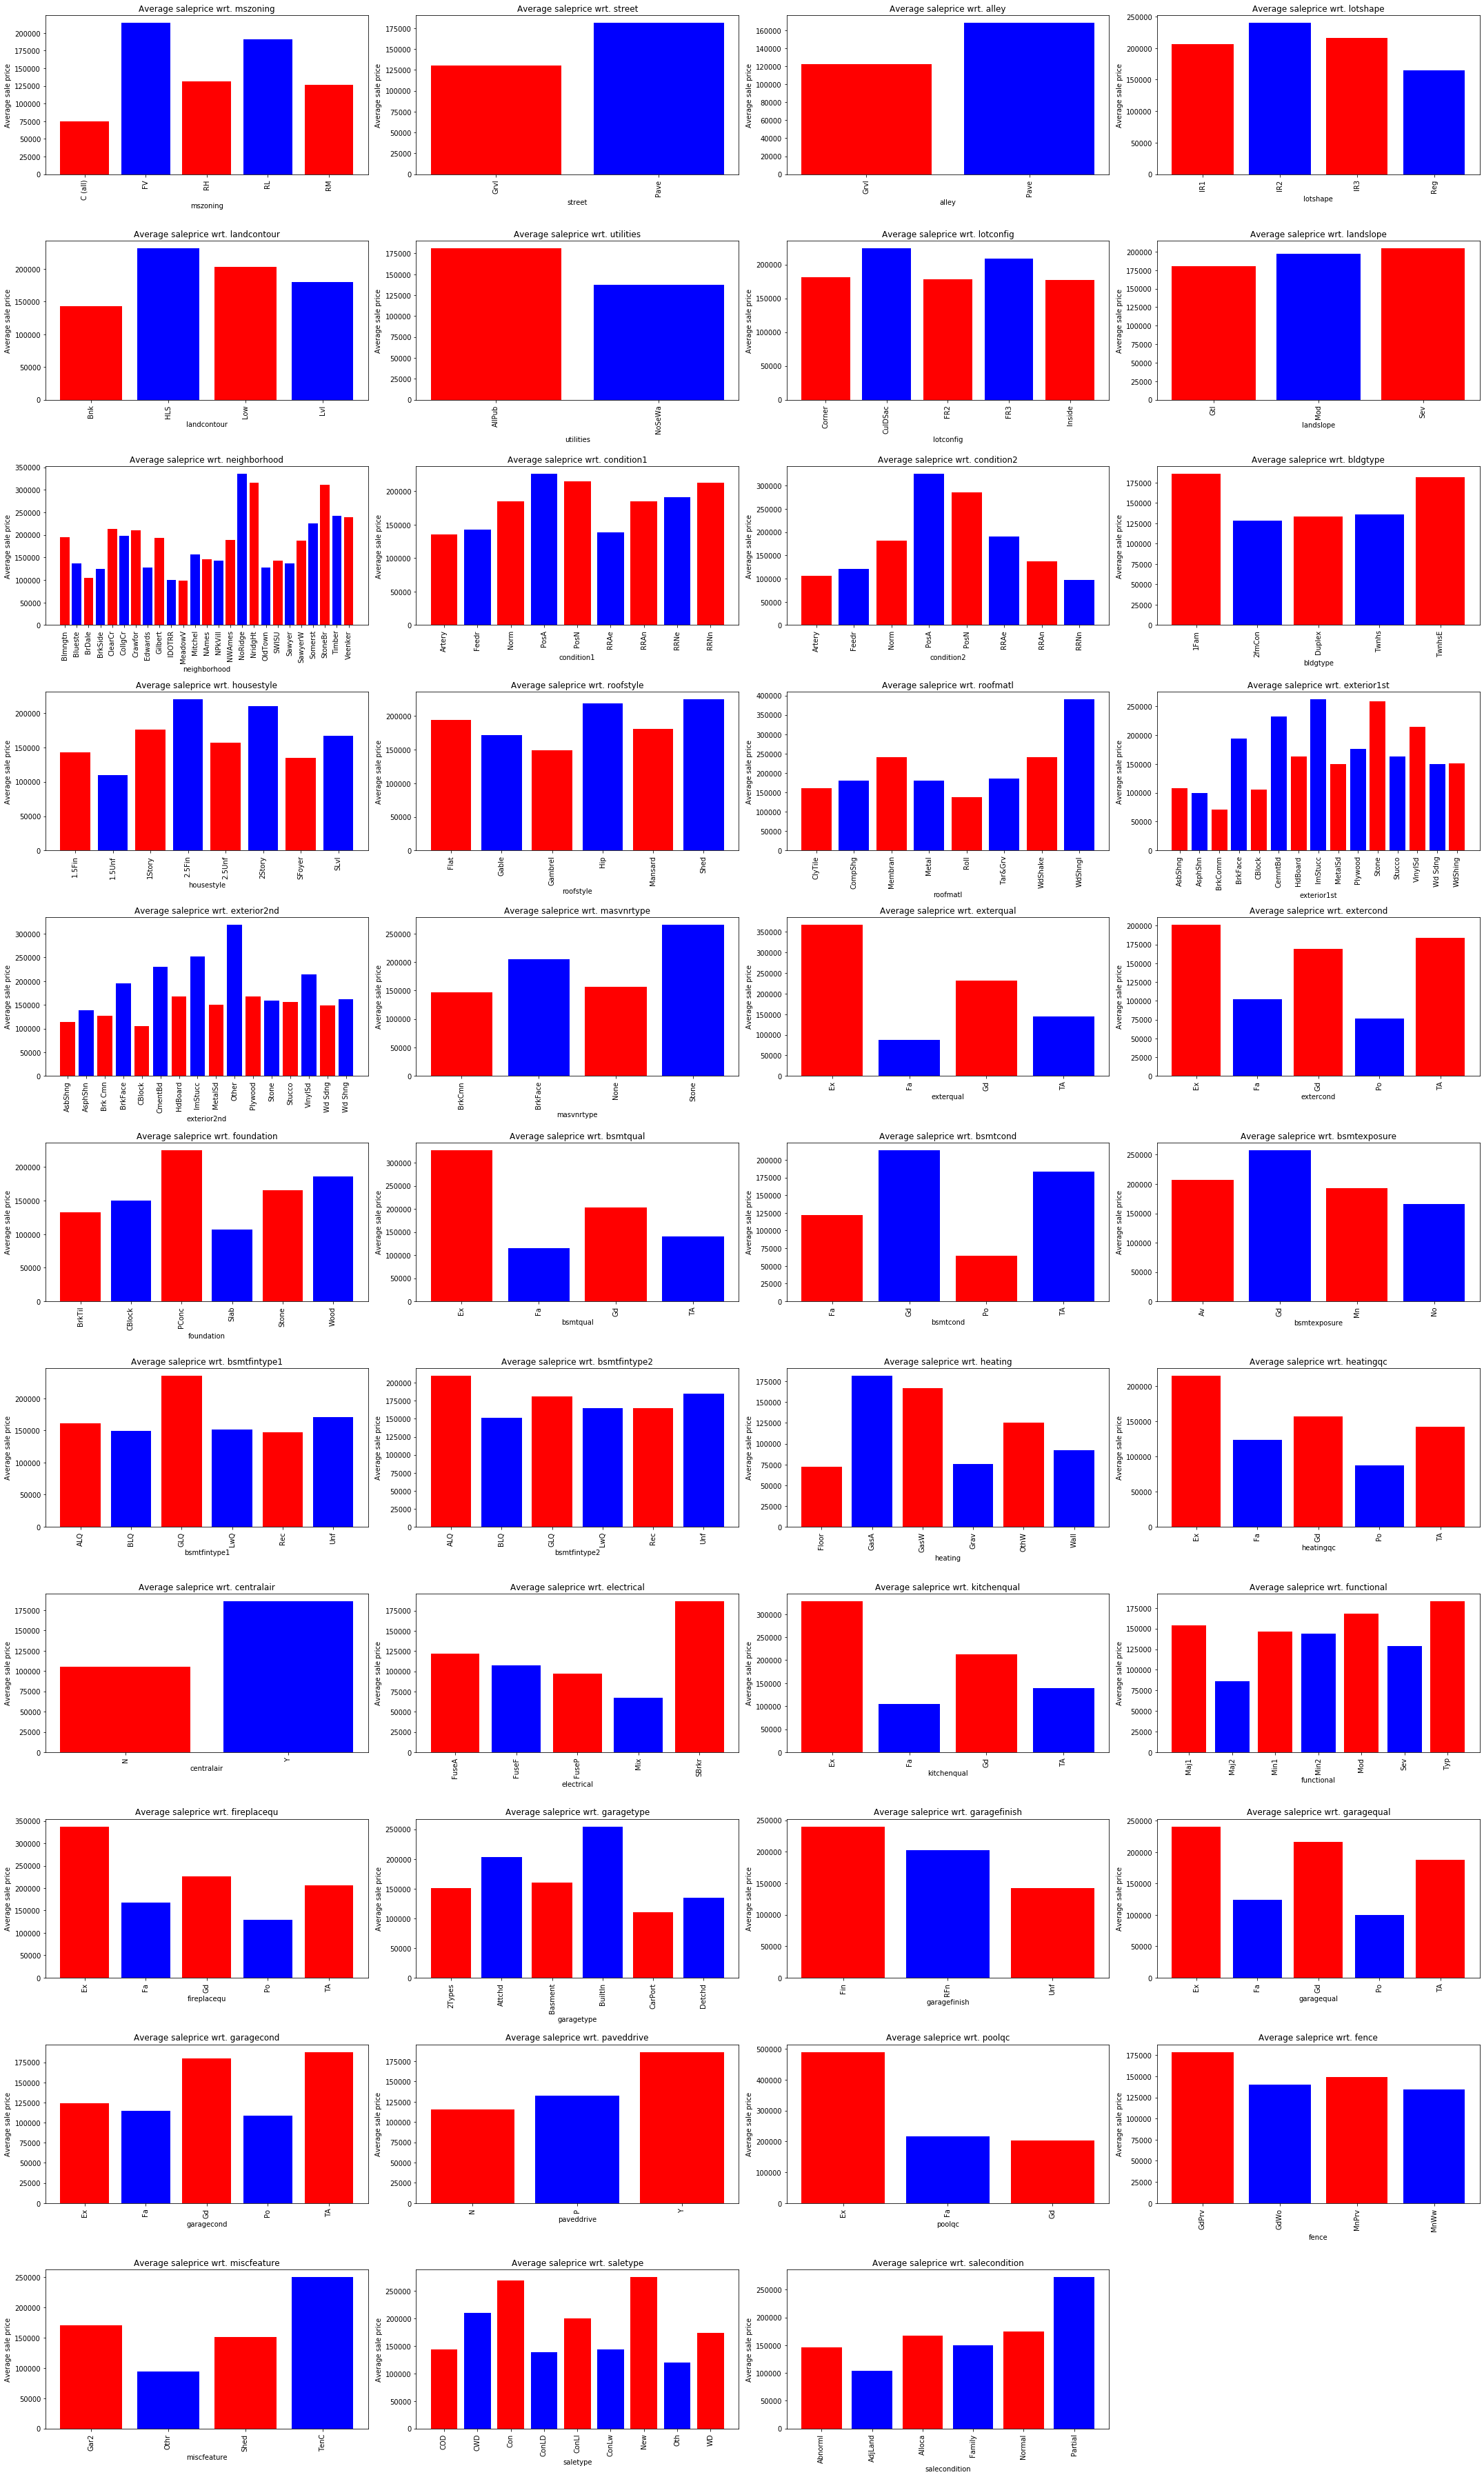

In [7]:
# Look into the categorical variables to see if there are any that show a lot of variance wrt saleprice.

plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(houses_df.groupby(column)["saleprice"].mean().index, houses_df.groupby(column)["saleprice"].mean(),
           color=("red","blue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [8]:
# This is where I played around with which categorical variables to include in my model. 
# I ended up selecting zoning and neighborhood.

houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
# houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.street, prefix="street", drop_first=True)], axis=1)
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
# houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.condition2, prefix="condition2", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True).columns) + list(pd.get_dummies(houses_df.neighborhood, prefix="neighborhood", drop_first=True).columns)
print(dummy_column_names)

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker']


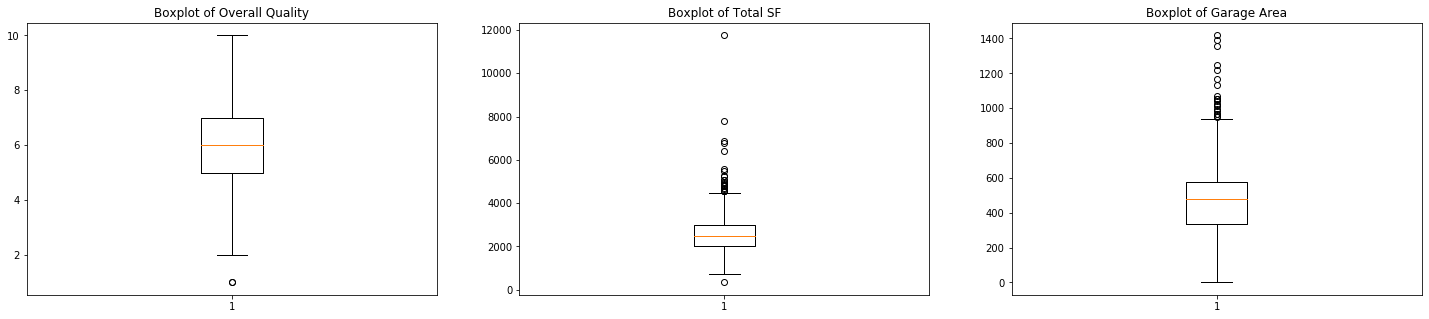

In [9]:
# I wanted to add together all of the square feet of the houses.
houses_df['totalsf'] = houses_df['totalbsmtsf'] + houses_df['firstflrsf'] + houses_df['secondflrsf']

# Check for outliers.
plt.figure(figsize=(25,5))

plt.subplot(1, 3, 1)
plt.boxplot(houses_df.overallqual)
plt.title("Boxplot of Overall Quality")

plt.subplot(1, 3, 2)
plt.boxplot(houses_df.totalsf)
plt.title("Boxplot of Total SF")

plt.subplot(1, 3, 3)
plt.boxplot(houses_df.garagearea)
plt.title("Boxplot of Garage Area")

plt.show()

There are some outliers in Total SF and Garage Area that I'll deal with later on.

Before I do that though I wanted to get a sense of the distributions and potential transformations that might be useful.

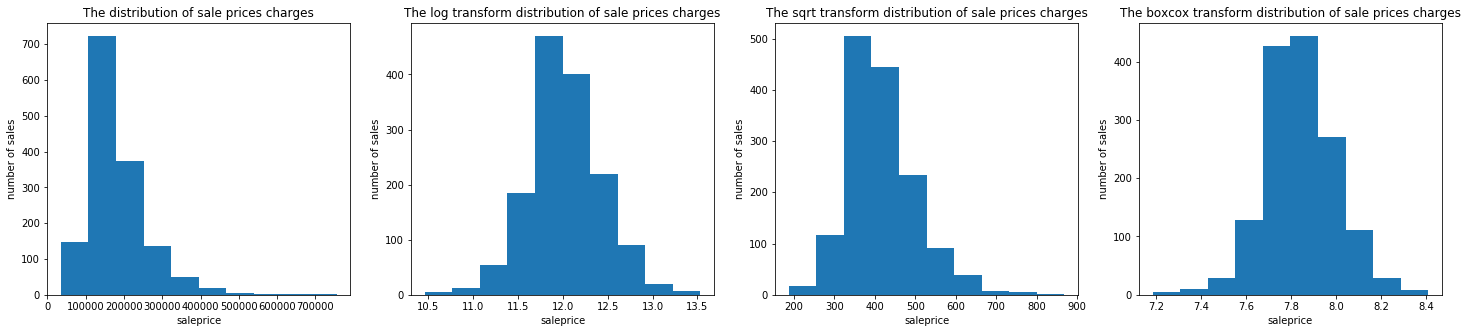

In [11]:
saleprice_boxcox, _ = stats.boxcox(houses_df.saleprice)

plt.figure(figsize=(25,5))

plt.subplot(1, 4, 1)
plt.hist(houses_df.saleprice)
plt.title("The distribution of sale prices charges")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

plt.subplot(1, 4, 2)
plt.hist(np.log(houses_df.saleprice))
plt.title("The log transform distribution of sale prices charges")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

plt.subplot(1, 4, 3)
plt.hist(np.sqrt(houses_df.saleprice))
plt.title("The sqrt transform distribution of sale prices charges")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

plt.subplot(1, 4, 4)
plt.hist(saleprice_boxcox)
plt.title("The boxcox transform distribution of sale prices charges")
plt.xlabel("saleprice")
plt.ylabel("number of sales")

plt.show()

I'll use the log transformed saleprice.

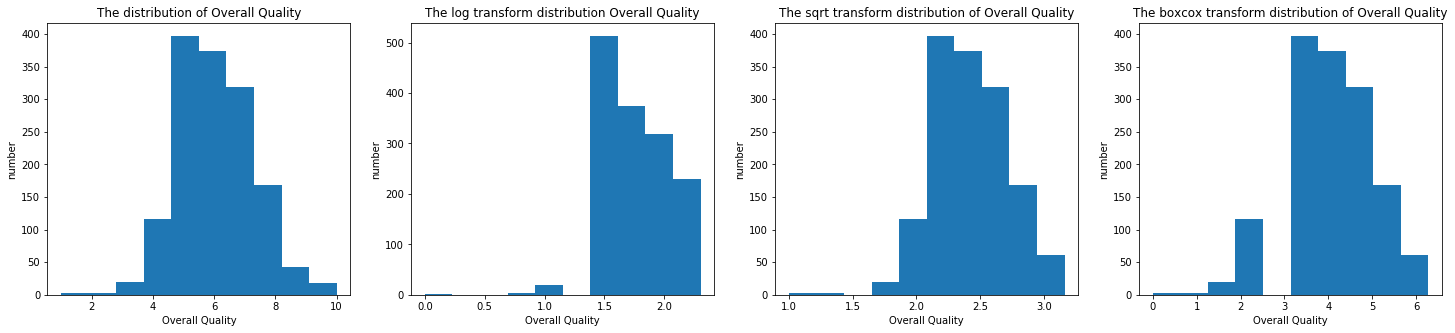

In [12]:
overallqual_boxcox, _ = stats.boxcox(houses_df.overallqual)

plt.figure(figsize=(25,5))

plt.subplot(1, 4, 1)
plt.hist(houses_df.overallqual)
plt.title("The distribution of Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("number")

plt.subplot(1, 4, 2)
plt.hist(np.log(houses_df.overallqual))
plt.title("The log transform distribution Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("number")

plt.subplot(1, 4, 3)
plt.hist(np.sqrt(houses_df.overallqual))
plt.title("The sqrt transform distribution of Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("number")

plt.subplot(1, 4, 4)
plt.hist(overallqual_boxcox)
plt.title("The boxcox transform distribution of Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("number")

plt.show()

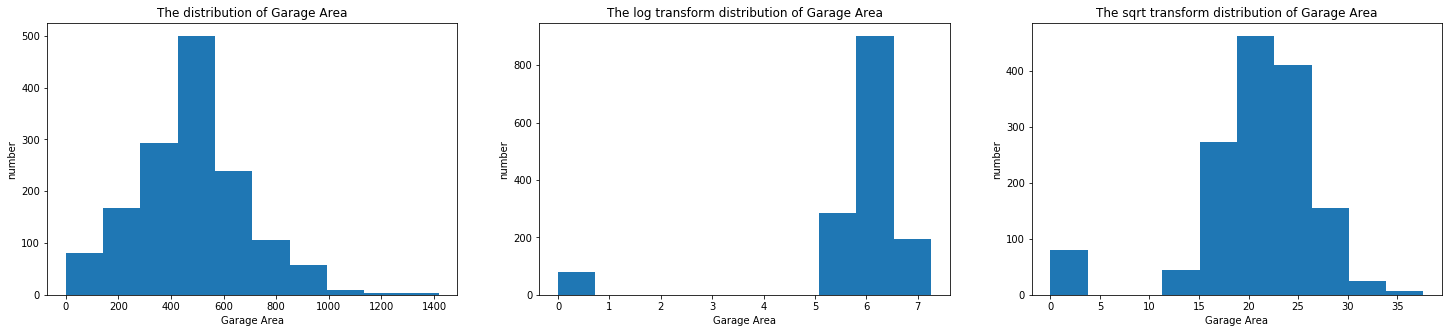

In [13]:
# garagearea_boxcox, _ = stats.boxcox(houses_df.garagearea) (Can't use due to 0 values)

plt.figure(figsize=(25,5))

plt.subplot(1, 3, 1)
plt.hist(houses_df.garagearea)
plt.title("The distribution of Garage Area")
plt.xlabel("Garage Area")
plt.ylabel("number")

plt.subplot(1, 3, 2) 
plt.hist(np.log1p(houses_df.garagearea))
plt.title("The log transform distribution of Garage Area")
plt.xlabel("Garage Area")
plt.ylabel("number")

plt.subplot(1, 3, 3)
plt.hist(np.sqrt(houses_df.garagearea))
plt.title("The sqrt transform distribution of Garage Area")
plt.xlabel("Garage Area")
plt.ylabel("number")

# plt.subplot(1, 4, 4)
# plt.hist(garagearea_boxcox)
# plt.title("The boxcox transform distribution of Garage Area")
# plt.xlabel("Garage Area")
# plt.ylabel("number")

plt.show()

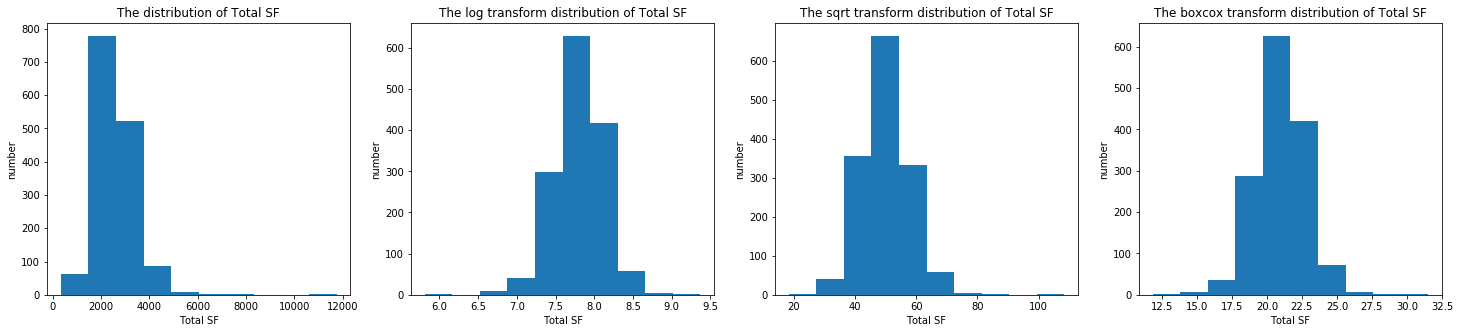

In [14]:
totalsf_boxcox, _ = stats.boxcox(houses_df.totalsf)

plt.figure(figsize=(25,5))

plt.subplot(1, 4, 1)
plt.hist(houses_df.totalsf)
plt.title("The distribution of Total SF")
plt.xlabel("Total SF")
plt.ylabel("number")

plt.subplot(1, 4, 2)
plt.hist(np.log(houses_df.totalsf))
plt.title("The log transform distribution of Total SF")
plt.xlabel("Total SF")
plt.ylabel("number")

plt.subplot(1, 4, 3)
plt.hist(np.sqrt(houses_df.totalsf))
plt.title("The sqrt transform distribution of Total SF")
plt.xlabel("Total SF")
plt.ylabel("number")

plt.subplot(1, 4, 4)
plt.hist(totalsf_boxcox)
plt.title("The boxcox transform distribution of Total SF")
plt.xlabel("Total SF")
plt.ylabel("number")

plt.show()

I'll use the log transformed Total SF as it appears more normally distributed. 

Below I decide to slightly winsorize garagearea and the log transform of totalsf to curtail the previously mentioned outliers.

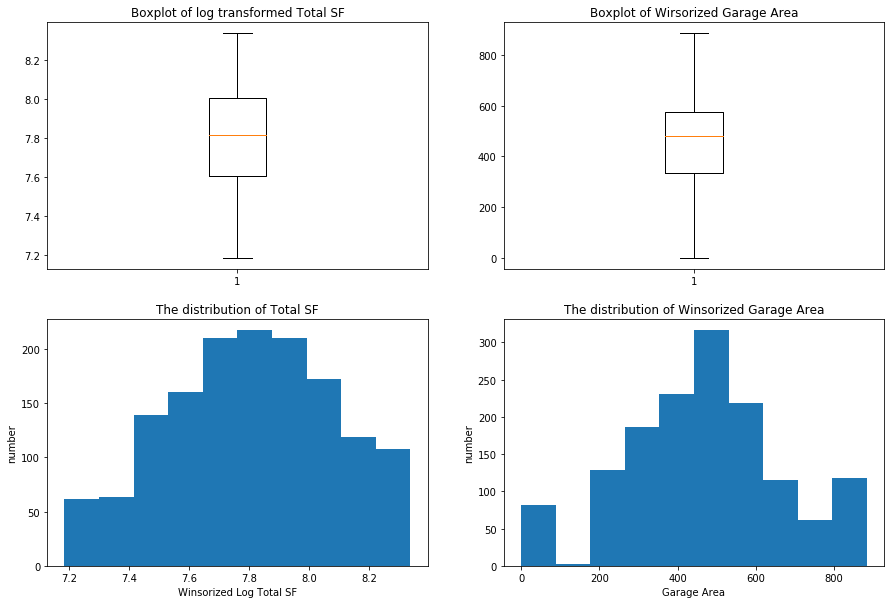

In [15]:
win_houses_df = pd.DataFrame()

win_houses_df["win_garagearea"] = winsorize(houses_df["garagearea"], (0, 0.03))
houses_df['win_garagearea'] = win_houses_df['win_garagearea']

houses_df['log_totalsf'] = np.log(houses_df['totalsf'])

win_houses_df["win_log_totalsf"] = winsorize(houses_df["log_totalsf"], (0.03, 0.03))
houses_df['win_log_totalsf'] = win_houses_df['win_log_totalsf']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.boxplot(houses_df.win_log_totalsf)
plt.title("Boxplot of log transformed Total SF")

plt.subplot(2, 2, 2)
plt.boxplot(houses_df.win_garagearea)
plt.title("Boxplot of Wirsorized Garage Area")

plt.subplot(2, 2, 3)
plt.hist(houses_df.win_log_totalsf)
plt.title("The distribution of Total SF")
plt.xlabel("Winsorized Log Total SF")
plt.ylabel("number")

plt.subplot(2, 2, 4)
plt.hist(houses_df.win_garagearea)
plt.title("The distribution of Winsorized Garage Area")
plt.xlabel("Garage Area")
plt.ylabel("number")

plt.show()

In [16]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(houses_df.saleprice) 
norm_stats = normaltest(houses_df.saleprice)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

log_jb_stats = jarque_bera(np.log(houses_df.saleprice)) 
log_norm_stats = normaltest(np.log(houses_df.saleprice)) 

print("Log Transformed Jarque-Bera test statistics is {0} and p value is {1}".format(log_jb_stats[0], log_jb_stats[1]))
print("Log Transformed Normality test statistics is {0} and p value is {1}".format(log_norm_stats[0], log_norm_stats[1]))

sqrt_jb_stats = jarque_bera(np.sqrt(houses_df.saleprice)) 
sqrt_norm_stats = normaltest(np.sqrt(houses_df.saleprice)) 

print("SQRT Transformed Jarque-Bera test statistics is {0} and p value is {1}".format(sqrt_jb_stats[0], sqrt_jb_stats[1]))
print("SQRT Transformed Normality test statistics is {0} and p value is {1}".format(sqrt_norm_stats[0], sqrt_norm_stats[1]))

boxcox_jb_stats = jarque_bera(saleprice_boxcox) 
boxcox_norm_stats = normaltest(saleprice_boxcox) 

print("Boxcox Transformed Jarque-Bera test statistics is {0} and p value is {1}".format(boxcox_jb_stats[0], boxcox_jb_stats[1]))
print("Boxcox Transformed Normality test statistics is {0} and p value is {1}".format(boxcox_norm_stats[0], boxcox_norm_stats[1]))

# print(stats.describe(houses_df.saleprice))
# print(stats.describe(np.log(houses_df.saleprice)))
# print(stats.describe(np.sqrt(houses_df.saleprice)))
# print(stats.describe(saleprice_boxcox))

Jarque-Bera test statistics is 3438.8721241220583 and p value is 0.0
Normality test statistics is 610.8359109472653 and p value is 2.283848353787728e-133
Log Transformed Jarque-Bera test statistics is 42.7672735832514 and p value is 5.166596039885007e-10
Log Transformed Normality test statistics is 25.507009834238268 and p value is 2.8921658220524008e-06
SQRT Transformed Jarque-Bera test statistics is 446.61660189638286 and p value is 0.0
SQRT Transformed Normality test statistics is 228.80624119955382 and p value is 2.0670739363119167e-50
Boxcox Transformed Jarque-Bera test statistics is 46.14340278837257 and p value is 9.551848201283519e-11
Boxcox Transformed Normality test statistics is 24.658476329182104 and p value is 4.420586560910238e-06


Unfortunately these tests show that no matter what my target variable isn't normally distrubted. But I chose to go with the log transform as it appeared to be the best and has the "largest" p values on the above tests.

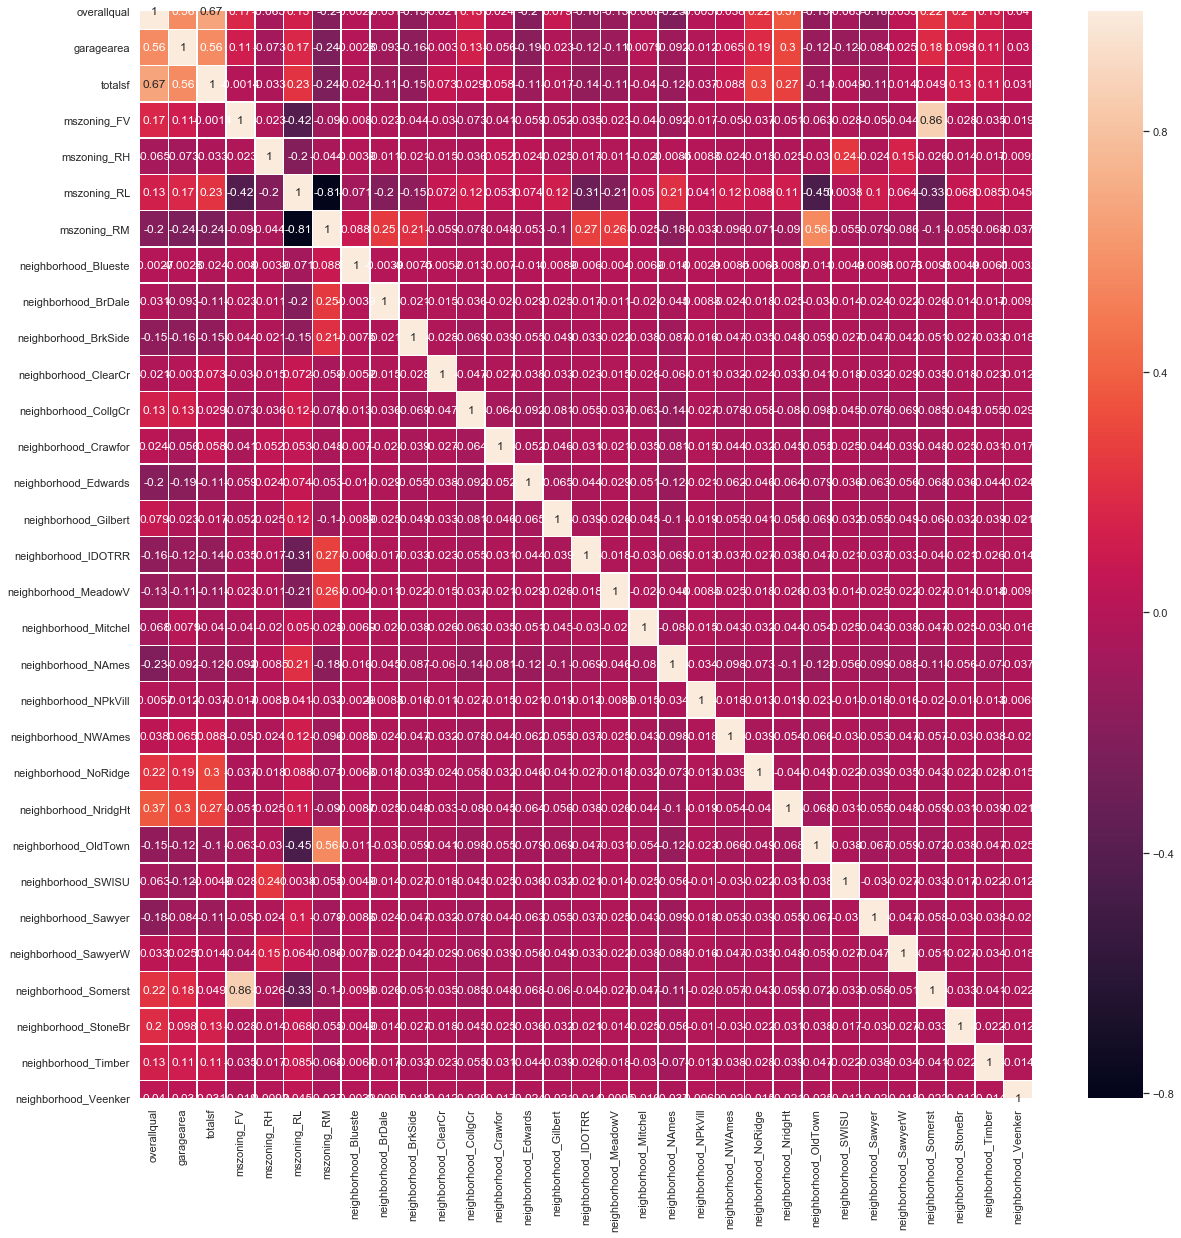

In [17]:
# Heat map of my variables. Showing that nothing is too closely correlated.

corrmat_houses = houses_df[['overallqual', 'garagearea', 'totalsf'] + dummy_column_names].corr()

sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmat_houses, annot=True, linewidths=.5, ax=ax)
plt.show()

# plt.figure(figsize=(10,10))
# sns.heatmap(corrmat_houses, square=True, annot=True)
# plt.title("correlation matrix (Saleprice Features)")
# plt.show()

There is relatively low collinearity between features. 

## Models with three numerical variables and no categorical variables.

In [18]:
Y = np.log(houses_df['saleprice'])
X = houses_df[['overallqual', 'win_garagearea', 'win_log_totalsf']] 
#   + dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

results = sm.OLS(y_train, X_train).fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1910.
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:39:35   Log-Likelihood:                 454.11
No. Observations:                1168   AIC:                            -900.2
Df Residuals:                    1164   BIC:                            -880.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.1608      0.171     35.999      0.000       5.825       6.497
overallqual         0.1224      0.005     24.726      0.000       0.113       0.132
win_garagearea      0.0003   3.01e-05     11.081      0.000       0.000       0.000
win_log_totalsf     0.6358      0.024     26.127      0.000       0.588       0.684
==============================================================================
Omnibus:                      158.993   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              447.328
Skew:                          -0.705   Prob(JB):                     7.31e-98
Kurtosis:                       5.683   Cond. No.                     1.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared of the model in training set is: 0.8311656297790361


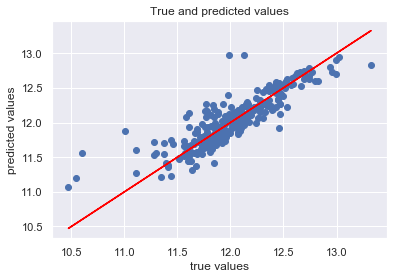

-----Test set statistics-----
R-squared of the model in the test set is: 0.7538833147750296
Mean absolute error of the prediction is: 0.1345150574513788
Mean squared error of the prediction is: 0.0393417464616637
Root mean squared error of the prediction is: 0.19834753959064805
Mean absolute percentage error of the prediction is: 1.133084708173353
-----Linear Assumption Tests-----
Mean of the errors is: -0.0024572339667762047
Bartlett test statistic value is 764.596 and p value is 2.69e-168
Levene test statistic value is 695.255 and p value is 1.29e-137


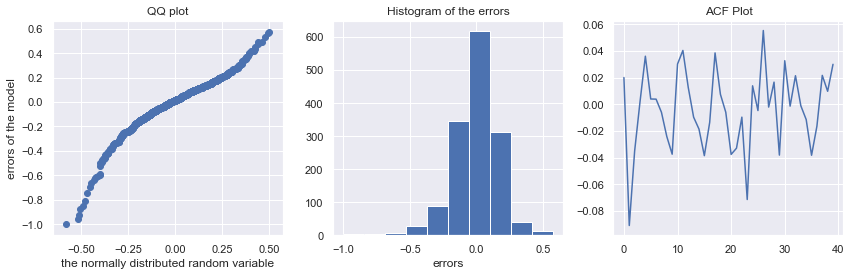

In [19]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lrm.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8311642955698259


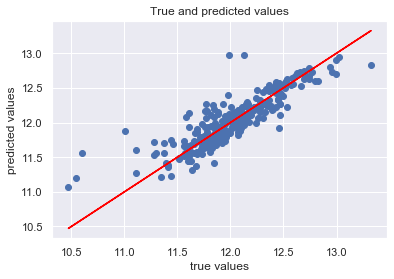

-----Test set statistics-----
R-squared of the model on the test set is: 0.7540648447231416
Mean absolute error of the prediction is: 0.13443569712586953
Mean squared error of the prediction is: 0.03931272890364116
Root mean squared error of the prediction is: 0.19827437782941384
Mean absolute percentage error of the prediction is: 1.1323927762361674
-----Linear Assumption Tests-----
Mean of the errors is: -0.002453962347893172
Bartlett test statistic value is 763.735 and p value is 4.14e-168
Levene test statistic value is 694.441 and p value is 1.8e-137


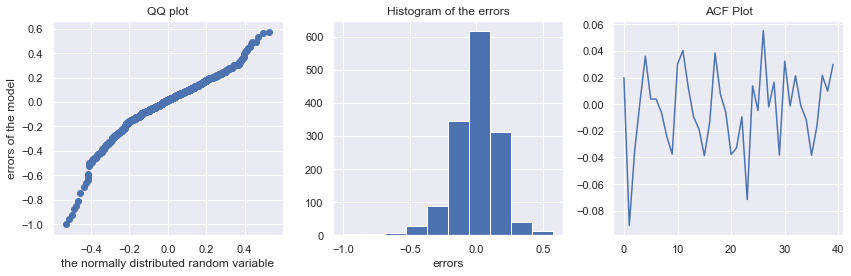

In [20]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lasso_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 0.1
R-squared of the model in training set is: 0.8311651739068361


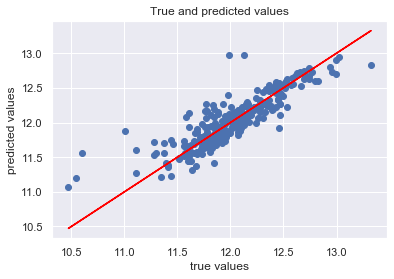

-----Test set statistics-----
R-squared of the model on the test set is: 0.7539877405771224
Mean absolute error of the prediction is: 0.13447114720708903
Mean squared error of the prediction is: 0.039325053999605585
Root mean squared error of the prediction is: 0.19830545630316274
Mean absolute percentage error of the prediction is: 1.1327002700219952
-----Linear Assumption Tests-----
Mean of the errors is: -0.0024543950423734574
Bartlett test statistic value is 764.213 and p value is 3.26e-168
Levene test statistic value is 694.912 and p value is 1.49e-137


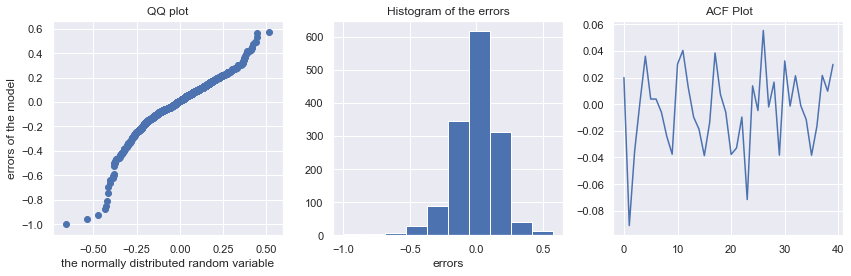

In [21]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = ridge_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8311646914696846


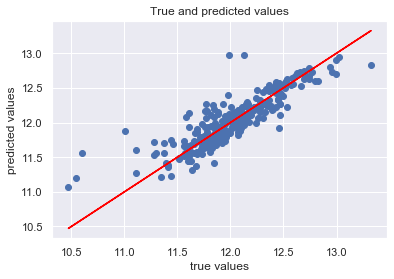

-----Test set statistics-----
R-squared of the model on the test set is: 0.754035009007602
Mean absolute error of the prediction is: 0.13444975622575428
Mean squared error of the prediction is: 0.03931749814208266
Root mean squared error of the prediction is: 0.1982864043299052
Mean absolute percentage error of the prediction is: 1.132514425528007
-----Linear Assumption Tests-----
Mean of the errors is: -0.00245394062507102
Bartlett test statistic value is 763.942 and p value is 3.73e-168
Levene test statistic value is 694.631 and p value is 1.67e-137


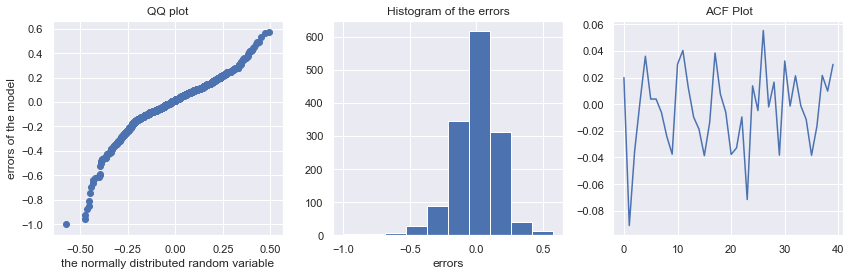

In [22]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = elasticnet_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

## Models with three numerical and two categorical variables (zoning and neighborhood)

In [23]:
Y = np.log(houses_df['saleprice'])
X = houses_df[['overallqual', 'win_garagearea', 'win_log_totalsf'] + dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

results = sm.OLS(y_train, X_train).fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     242.0
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:39:42   Log-Likelihood:                 600.01
No. Observations:                1168   AIC:                            -1136.
Df Residuals:                    1136   BIC:                            -974.0
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.4830      0.186     34.920      0.000       6.119       6.847
overallqual              0.0995      0.005     18.640      0.000       0.089       0.110
win_garagearea           0.0003   2.86e-05     10.334      0.000       0.000       0.000
win_log_totalsf          0.5665      0.024     24.079      0.000       0.520       0.613
mszoning_FV              0.3926      0.078      5.048      0.000       0.240       0.545
mszoning_RH              0.2782      0.079      3.533      0.000       0.124       0.433
mszoning_RL              0.3425      0.065      5.251      0.000       0.214       0.470
mszoning_RM              0.3014      0.062      4.869      0.000       0.180       0.423
neighborhood_Blueste    -0.0003      0.115     -0.003      0.998      -0.226       0.225
neighborhood_BrDale     -0.1132      0.063     -1.789      0.074      -0.237       0.011
neighborhood_BrkSide    -0.0192      0.052     -0.372      0.710      -0.120       0.082
neighborhood_ClearCr     0.1435      0.054      2.642      0.008       0.037       0.250
neighborhood_CollgCr     0.0669      0.046      1.446      0.148      -0.024       0.158
neighborhood_Crawfor     0.1759      0.050      3.516      0.000       0.078       0.274
neighborhood_Edwards    -0.0147      0.048     -0.304      0.761      -0.110       0.080
neighborhood_Gilbert     0.1196      0.048      2.493      0.013       0.025       0.214
neighborhood_IDOTRR     -0.0909      0.059     -1.549      0.122      -0.206       0.024
neighborhood_MeadowV    -0.0410      0.065     -0.629      0.530      -0.169       0.087
neighborhood_Mitchel     0.0239      0.050      0.475      0.635      -0.075       0.123
neighborhood_NAmes       0.0103      0.046      0.223      0.824      -0.080       0.101
neighborhood_NPkVill    -0.0462      0.068     -0.674      0.500      -0.181       0.088
neighborhood_NWAmes      0.0046      0.049      0.095      0.924      -0.091       0.100
neighborhood_NoRidge     0.2268      0.051      4.404      0.000       0.126       0.328
neighborhood_NridgHt     0.1447      0.049      2.971      0.003       0.049       0.240
neighborhood_OldTown    -0.0685      0.051     -1.351      0.177      -0.168       0.031
neighborhood_SWISU      -0.0376      0.056     -0.669      0.503      -0.148       0.073
neighborhood_Sawyer      0.0222      0.049      0.450      0.652      -0.075       0.119
neighborhood_SawyerW     0.0543      0.050      1.094      0.274      -0.043       0.152
neighborhood_Somerst     0.0440      0.058      0.762      0.446      -0.069       0.157
neighborhood_StoneBr     0.1931      0.057      3.384      0.001       0.081       0.305
neighborhood_Timber      0.1112      0.051      2.164      0.031       0.010       0.212
neighborhood_Veenker     0.2103      0.068      3.081    

R-squared of the model in training set is: 0.8684889206124329


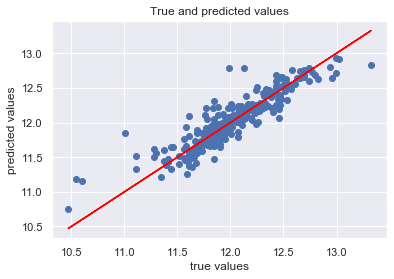

-----Test set statistics-----
R-squared of the model in the test set is: 0.8192316696565363
Mean absolute error of the prediction is: 0.11640019582632807
Mean squared error of the prediction is: 0.02889581343975161
Root mean squared error of the prediction is: 0.16998768614153087
Mean absolute percentage error of the prediction is: 0.9780804762179814
-----Linear Assumption Tests-----
Mean of the errors is: -0.0018724574536009351
Bartlett test statistic value is 1074.47 and p value is 1.17e-235
Levene test statistic value is 919.629 and p value is 7.77e-176


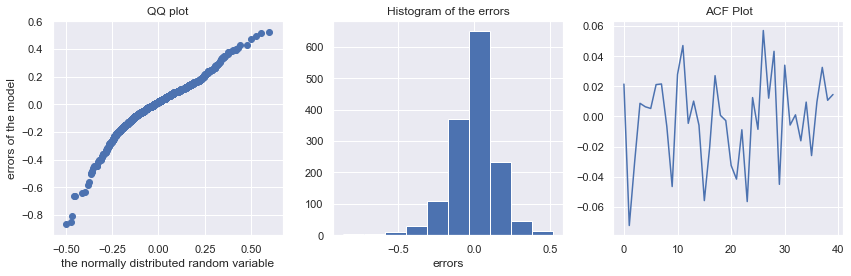

In [24]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lrm.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

## Of all the models I tested, the above Linear Regression model with three numerical and two categorical values is the most accurate on the test set. 

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.8684845540368015


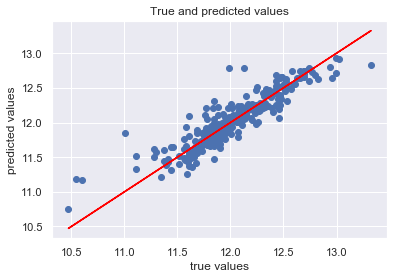

-----Test set statistics-----
R-squared of the model on the test set is: 0.819053194052803
Mean absolute error of the prediction is: 0.11642050780063334
Mean squared error of the prediction is: 0.02892434276089556
Root mean squared error of the prediction is: 0.17007158128533867
Mean absolute percentage error of the prediction is: 0.978298913859533
-----Linear Assumption Tests-----
Mean of the errors is: -0.001884615401045764
Bartlett test statistic value is 1073.53 and p value is 1.88e-235
Levene test statistic value is 919.867 and p value is 7.1e-176


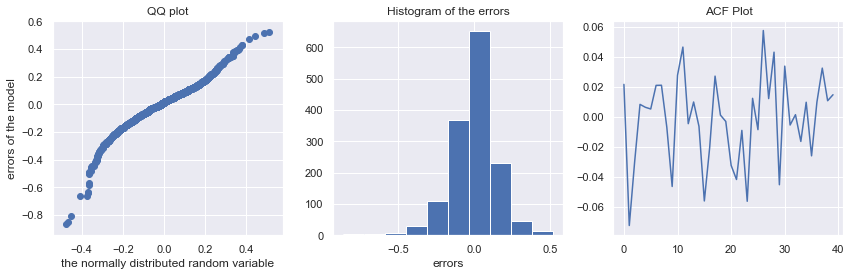

In [25]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lasso_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8677851363679884


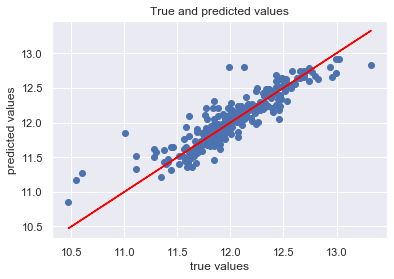

-----Test set statistics-----
R-squared of the model on the test set is: 0.8162457402480598
Mean absolute error of the prediction is: 0.11656904770532732
Mean squared error of the prediction is: 0.02937311418688838
Root mean squared error of the prediction is: 0.1713858634394575
Mean absolute percentage error of the prediction is: 0.9801374440219087
-----Linear Assumption Tests-----
Mean of the errors is: -0.0019314342139312923
Bartlett test statistic value is 1055.2 and p value is 1.8e-231
Levene test statistic value is 917.216 and p value is 1.95e-175


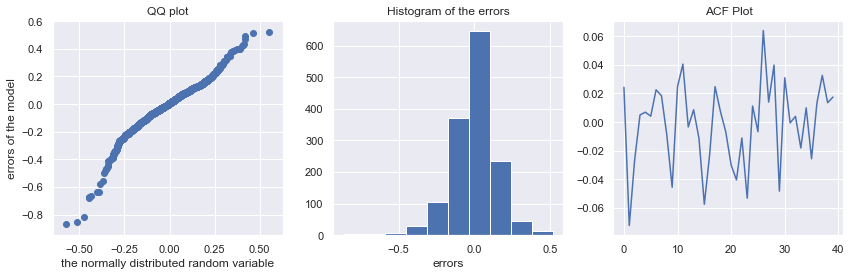

In [26]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = ridge_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.868486900060151


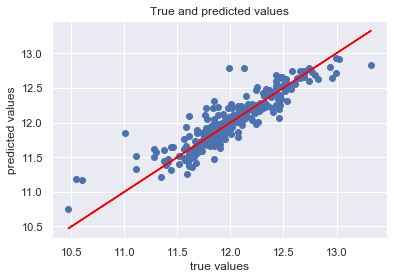

-----Test set statistics-----
R-squared of the model on the test set is: 0.8191154208169567
Mean absolute error of the prediction is: 0.11641618080584505
Mean squared error of the prediction is: 0.028914395814079556
Root mean squared error of the prediction is: 0.17004233535822647
Mean absolute percentage error of the prediction is: 0.9782463567745968
-----Linear Assumption Tests-----
Mean of the errors is: -0.0018809334119093417
Bartlett test statistic value is 1073.87 and p value is 1.58e-235
Levene test statistic value is 919.859 and p value is 7.12e-176


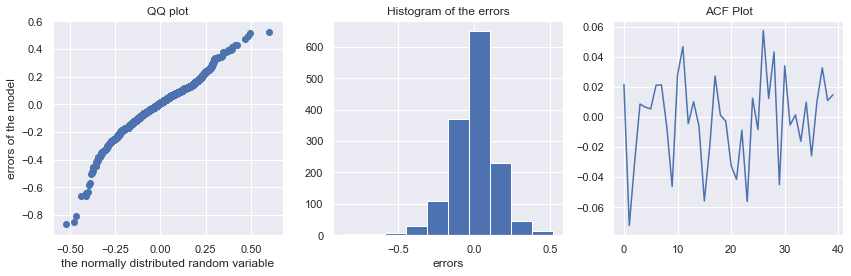

In [27]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = elasticnet_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

## Models with three numerical, two categorical, and one broad economic indicator.

In [28]:
houses_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,totalsf,win_garagearea,log_totalsf,win_log_totalsf
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,0,0,0,0,2566,548,7.850104,7.850104
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,0,0,0,1,2524,460,7.833600,7.833600
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,0,0,0,0,2706,608,7.903227,7.903227
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,0,0,0,0,2473,642,7.813187,7.813187
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,0,0,0,0,3343,836,8.114624,8.114624


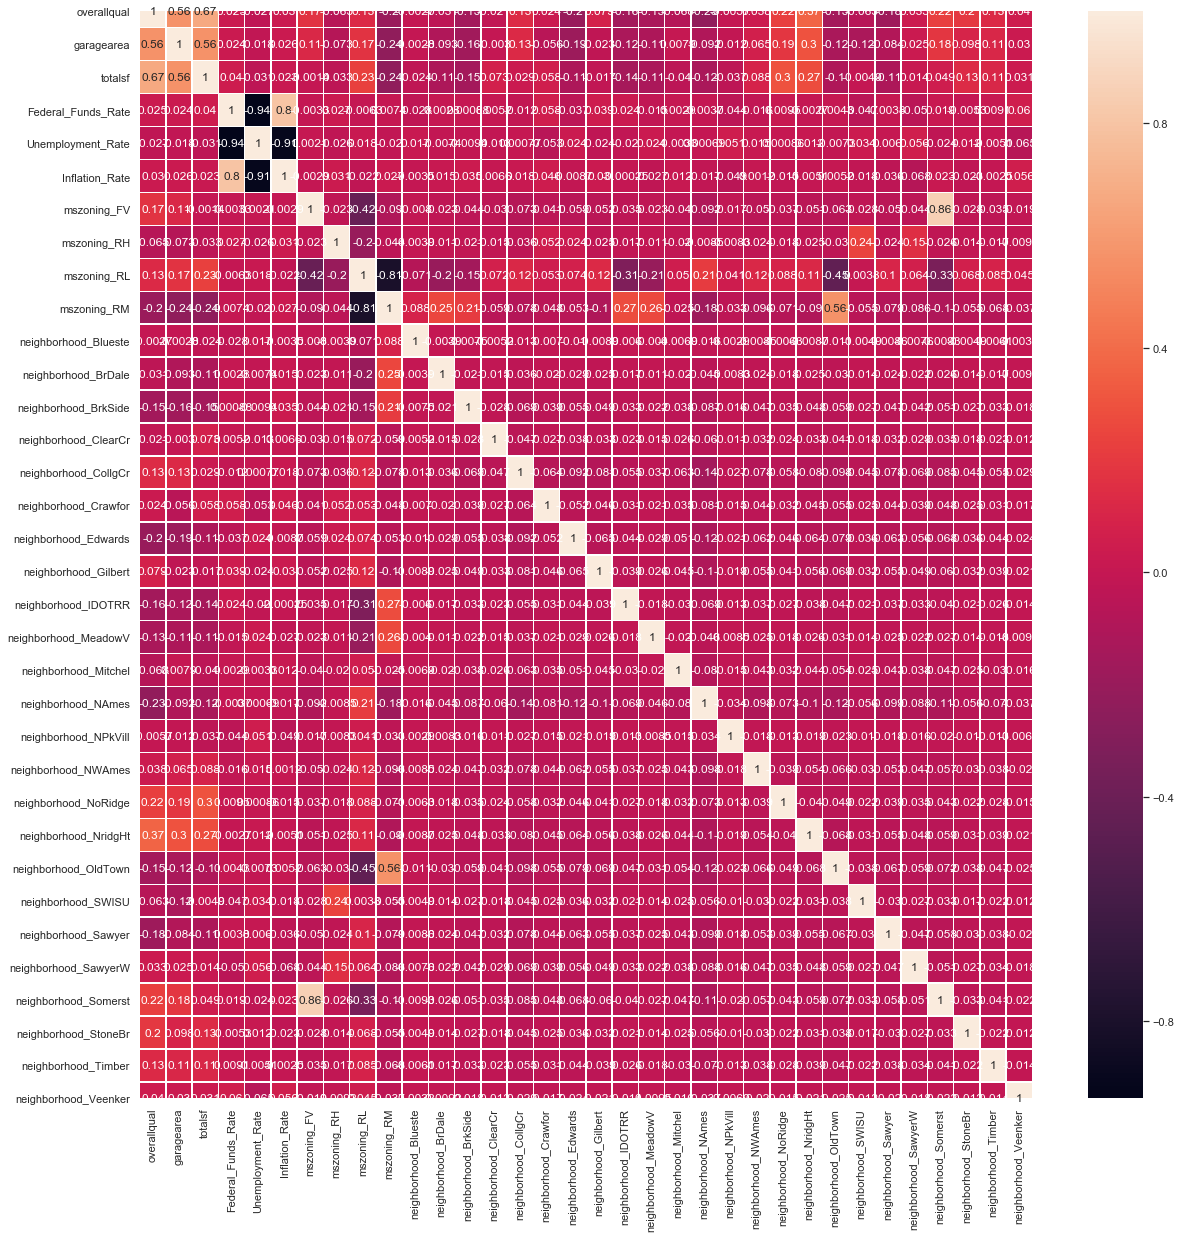

In [29]:
corrmat_houses = houses_df[['overallqual', 'garagearea', 'totalsf', 'Federal_Funds_Rate', 'Unemployment_Rate', 'Inflation_Rate'] + dummy_column_names].corr()


sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmat_houses, annot=True, linewidths=.5, ax=ax)
plt.show()

Because the Inflation Rate, Unemployment Rate and Federal Funds Rate are so strongly corrleated with each other I will only use one of them.

In [30]:
Y = np.log(houses_df['saleprice'])
X = houses_df[['overallqual', 'win_garagearea', 'win_log_totalsf', 'Federal_Funds_Rate'] + dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     234.4
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:41:36   Log-Likelihood:                 600.45
No. Observations:                1168   AIC:                            -1135.
Df Residuals:                    1135   BIC:                            -967.8
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.4815      0.186     34.908      0.000       6.117       6.846
overallqual              0.0996      0.005     18.656      0.000       0.089       0.110
win_garagearea           0.0003   2.86e-05     10.323      0.000       0.000       0.000
win_log_totalsf          0.5664      0.024     24.073      0.000       0.520       0.613
Federal_Funds_Rate       0.0019      0.002      0.917      0.360      -0.002       0.006
mszoning_FV              0.3901      0.078      5.013      0.000       0.237       0.543
mszoning_RH              0.2724      0.079      3.449      0.001       0.117       0.427
mszoning_RL              0.3379      0.065      5.165      0.000       0.210       0.466
mszoning_RM              0.2972      0.062      4.789      0.000       0.175       0.419
neighborhood_Blueste     0.0035      0.115      0.031      0.976      -0.222       0.229
neighborhood_BrDale     -0.1126      0.063     -1.779      0.076      -0.237       0.012
neighborhood_BrkSide    -0.0176      0.052     -0.342      0.733      -0.119       0.084
neighborhood_ClearCr     0.1441      0.054      2.653      0.008       0.038       0.251
neighborhood_CollgCr     0.0683      0.046      1.476      0.140      -0.022       0.159
neighborhood_Crawfor     0.1756      0.050      3.509      0.000       0.077       0.274
neighborhood_Edwards    -0.0129      0.048     -0.268      0.789      -0.108       0.082
neighborhood_Gilbert     0.1197      0.048      2.496      0.013       0.026       0.214
neighborhood_IDOTRR     -0.0914      0.059     -1.557      0.120      -0.206       0.024
neighborhood_MeadowV    -0.0385      0.065     -0.589      0.556      -0.167       0.090
neighborhood_Mitchel     0.0252      0.050      0.500      0.617      -0.074       0.124
neighborhood_NAmes       0.0116      0.046      0.251      0.802      -0.079       0.102
neighborhood_NPkVill    -0.0419      0.069     -0.610      0.542      -0.177       0.093
neighborhood_NWAmes      0.0066      0.049      0.134      0.893      -0.089       0.102
neighborhood_NoRidge     0.2279      0.052      4.424      0.000       0.127       0.329
neighborhood_NridgHt     0.1457      0.049      2.992      0.003       0.050       0.241
neighborhood_OldTown    -0.0677      0.051     -1.335      0.182      -0.167       0.032
neighborhood_SWISU      -0.0345      0.056     -0.613      0.540      -0.145       0.076
neighborhood_Sawyer      0.0238      0.049      0.483      0.629      -0.073       0.121
neighborhood_SawyerW     0.0565      0.050      1.137      0.256      -0.041       0.154
neighborhood_Somerst     0.0431      0.058      0.746      0.456      -0.070       0.156
neighborhood_StoneBr     0.1952      0.057      3.418      0.001       0.083       0.307
neighborhood_Timber      0.1126      0.051      2.189    

## As we can see from the above, the Federal Funds Rate has a pretty miniscule impact on our model, and doesn't improve its accuracy.

R-squared of the model in training set is: 0.8685861949253094


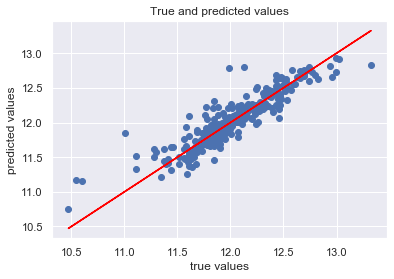

-----Test set statistics-----
R-squared of the model in the test set is: 0.8187202308019647
Mean absolute error of the prediction is: 0.11669914169129311
Mean squared error of the prediction is: 0.028977566928869217
Root mean squared error of the prediction is: 0.1702279851518816
Mean absolute percentage error of the prediction is: 0.9805444076799074
-----Linear Assumption Tests-----
Mean of the errors is: -0.0019530908899295265
Bartlett test statistic value is 1074.72 and p value is 1.03e-235
Levene test statistic value is 917.035 and p value is 2.09e-175


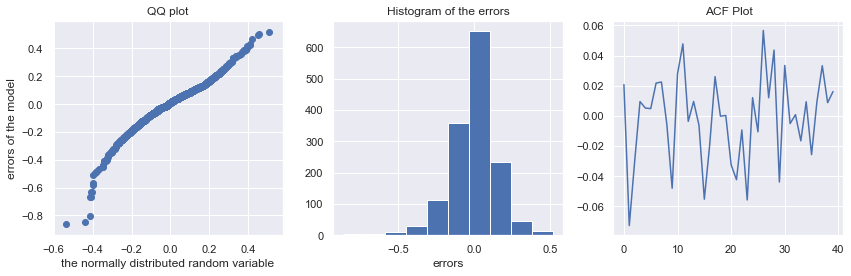

In [31]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lrm.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1e-06
R-squared of the model in training set is: 0.8685861222576827


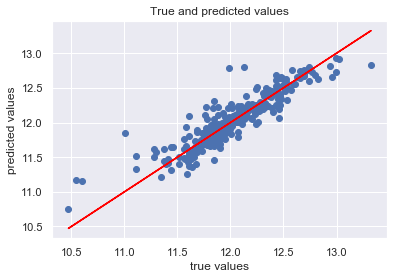

-----Test set statistics-----
R-squared of the model on the test set is: 0.8187020826607107
Mean absolute error of the prediction is: 0.11670032824072196
Mean squared error of the prediction is: 0.02898046790883046
Root mean squared error of the prediction is: 0.1702365058053955
Mean absolute percentage error of the prediction is: 0.9805598372647951
-----Linear Assumption Tests-----
Mean of the errors is: -0.001955406224518226
Bartlett test statistic value is 1074.63 and p value is 1.08e-235
Levene test statistic value is 917.121 and p value is 2.02e-175


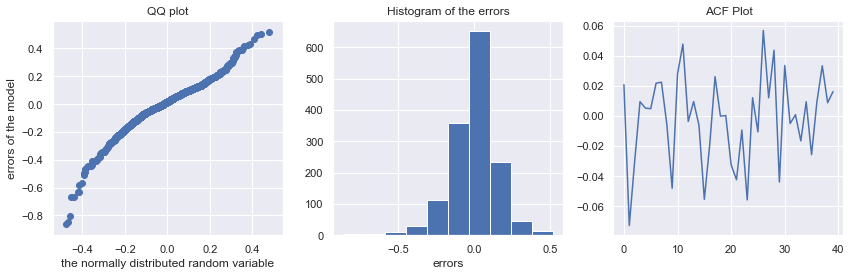

In [32]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = lasso_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8678928207268339


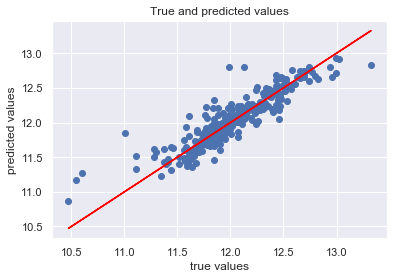

-----Test set statistics-----
R-squared of the model on the test set is: 0.8156181716302997
Mean absolute error of the prediction is: 0.11691232590617491
Mean squared error of the prediction is: 0.029473431015975556
Root mean squared error of the prediction is: 0.17167827764739357
Mean absolute percentage error of the prediction is: 0.9829808160150827
-----Linear Assumption Tests-----
Mean of the errors is: -0.0020299195567848845
Bartlett test statistic value is 1055.53 and p value is 1.53e-231
Levene test statistic value is 915.009 and p value is 4.52e-175


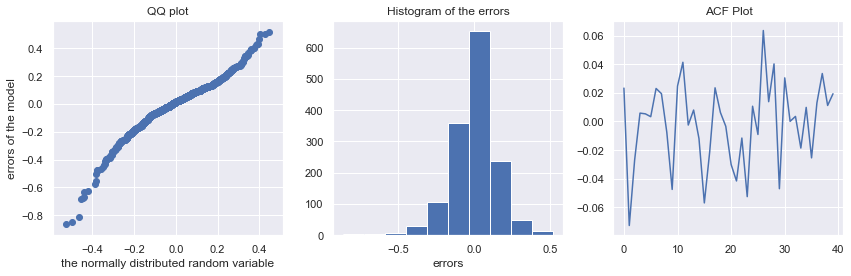

In [33]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = ridge_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.8685840633684104


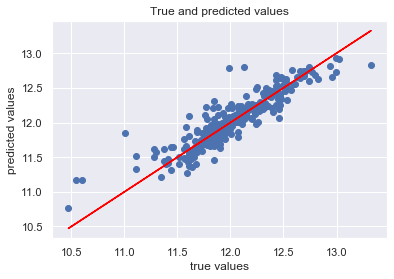

-----Test set statistics-----
R-squared of the model on the test set is: 0.8186006935292842
Mean absolute error of the prediction is: 0.11670834986751055
Mean squared error of the prediction is: 0.028996674959152553
Root mean squared error of the prediction is: 0.1702841007233281
Mean absolute percentage error of the prediction is: 0.9806558421304565
-----Linear Assumption Tests-----
Mean of the errors is: -0.0019638481642180873
Bartlett test statistic value is 1074.12 and p value is 1.39e-235
Levene test statistic value is 917.519 and p value is 1.74e-175


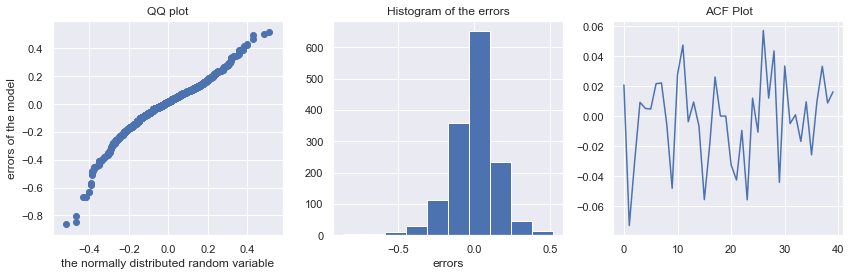

In [34]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("True and predicted values")
plt.show()

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

predictions = elasticnet_cv.predict(X)
errors = Y - predictions

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("-----Linear Assumption Tests-----")
print("Mean of the errors is: {}".format(np.mean(errors)))
print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.subplot(1,3,3)
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.title("ACF Plot")

plt.tight_layout()
plt.show()